# Imports

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sns.set(style="whitegrid", palette="muted", font_scale=1.1)


# Load processed dataset

In [18]:
df = pd.read_csv("../data/processed/municipalities_connectivity_processed.csv")
df.head()

,year,state,state_name,municipality_id,municipality_name,ibc,coverage_4g5g,fibra,density_smp,hhi_smp,density_scm,hhi_scm,stations_density,region,fiber_cat,ibc_decile
0,2024,RO,Rondônia,1100296,Santa Luzia D'Oeste,49.92,62.9831,100,44.00,51,23.87,47,25.39,N,full,5
1,2024,AC,Acre,1200351,Marechal Thaumaturgo,16.28,30.3470,0,36.72,16,8.04,33,8.36,N,none,1
2,2024,AM,Amazonas,1300839,Caapiranga,29.17,50.9133,50,26.62,7,0.65,71,17.47,N,partial,1
3,2024,AM,Amazonas,1302207,Juruá,20.06,53.3310,0,36.33,36,5.85,19,13.45,N,none,1
4,2024,PA,Pará,1501204,Baião,34.08,52.8200,100,20.46,15,2.85,52,6.26,N,full,2


# Select features for clustering

In [19]:
features = [
    "ibc",
    "coverage_4g5g",
    "density_smp",
    "density_scm",
    "stations_density"
]

X = df[features].dropna()
X.shape

(22280, 5)

# StandardScaler

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit KMeans

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe

In [22]:
df_clust = df.loc[X.index].copy()
df_clust["cluster"] = labels
df_clust.head()

,year,state,state_name,municipality_id,municipality_name,ibc,coverage_4g5g,fibra,density_smp,hhi_smp,density_scm,hhi_scm,stations_density,region,fiber_cat,ibc_decile,cluster
0,2024,RO,Rondônia,1100296,Santa Luzia D'Oeste,49.92,62.9831,100,44.00,51,23.87,47,25.39,N,full,5,0
1,2024,AC,Acre,1200351,Marechal Thaumaturgo,16.28,30.3470,0,36.72,16,8.04,33,8.36,N,none,1,0
2,2024,AM,Amazonas,1300839,Caapiranga,29.17,50.9133,50,26.62,7,0.65,71,17.47,N,partial,1,0
3,2024,AM,Amazonas,1302207,Juruá,20.06,53.3310,0,36.33,36,5.85,19,13.45,N,none,1,0
4,2024,PA,Pará,1501204,Baião,34.08,52.8200,100,20.46,15,2.85,52,6.26,N,full,2,0


# Silhouette Score (cluster quality)

In [24]:
silhouette = silhouette_score(X_scaled, labels)
silhouette

0.32739605533398763

# Profile each cluster

In [25]:
cluster_profile = df_clust.groupby("cluster")[features].mean().round(2)
cluster_profile

,ibc,coverage_4g5g,density_smp,density_scm,stations_density
cluster,,,,,
0,38.91,64.03,43.58,6.99,13.06
1,59.16,90.61,72.37,16.48,12.38
2,63.84,87.98,61.74,47.42,40.88


# Assign human-readable names

In [26]:
mapping = (
    cluster_profile["ibc"]
    .sort_values()
    .reset_index()
    .assign(label=["Critical","Medium","High"])
    .set_index("cluster")["label"]
    .to_dict()
)

df_clust["cluster_label"] = df_clust["cluster"].map(mapping)
df_clust[["cluster", "cluster_label"]].head()

,cluster,cluster_label
0,0,Critical
1,0,Critical
2,0,Critical
3,0,Critical
4,0,Critical


# Cluster × Region

In [27]:
pd.crosstab(df_clust["cluster_label"], df_clust["region"], normalize="index").round(2)

region,CO,N,NE,S,SE
cluster_label,,,,,
Critical,0.08,0.15,0.51,0.13,0.14
High,0.06,0.02,0.09,0.35,0.48
Medium,0.09,0.04,0.23,0.25,0.38


# Cluster × Fiber Category

In [28]:
pd.crosstab(df_clust["cluster_label"], df_clust["fiber_cat"], normalize="index").round(2)

fiber_cat,full,none,partial
cluster_label,,,
Critical,0.51,0.41,0.08
High,0.73,0.10,0.16
Medium,0.91,0.08,0.01


# Cluster × Market Concentration (HHI)

In [29]:
df_clust.groupby("cluster_label")[["hhi_smp", "hhi_scm"]].mean().round(1)

,hhi_smp,hhi_scm
cluster_label,,
Critical,37.9,53.8
High,44.6,53.6
Medium,55.6,58.7


# Boxplot of IBC per cluster

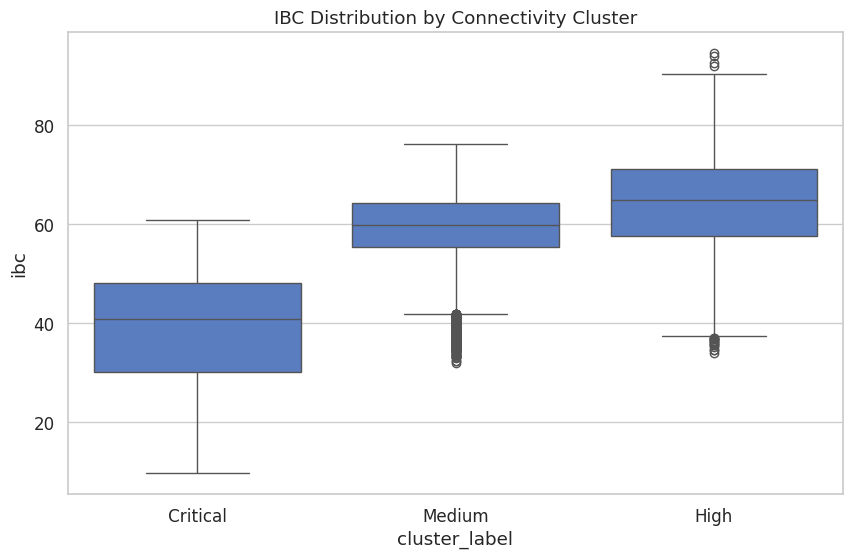

In [30]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_clust, x="cluster_label", y="ibc", order=["Critical","Medium","High"])
plt.title("IBC Distribution by Connectivity Cluster")
plt.savefig("../reports/figures/clusters/ibc_by_cluster.png", dpi=300)
plt.show()

# Pairplot colored by clusters

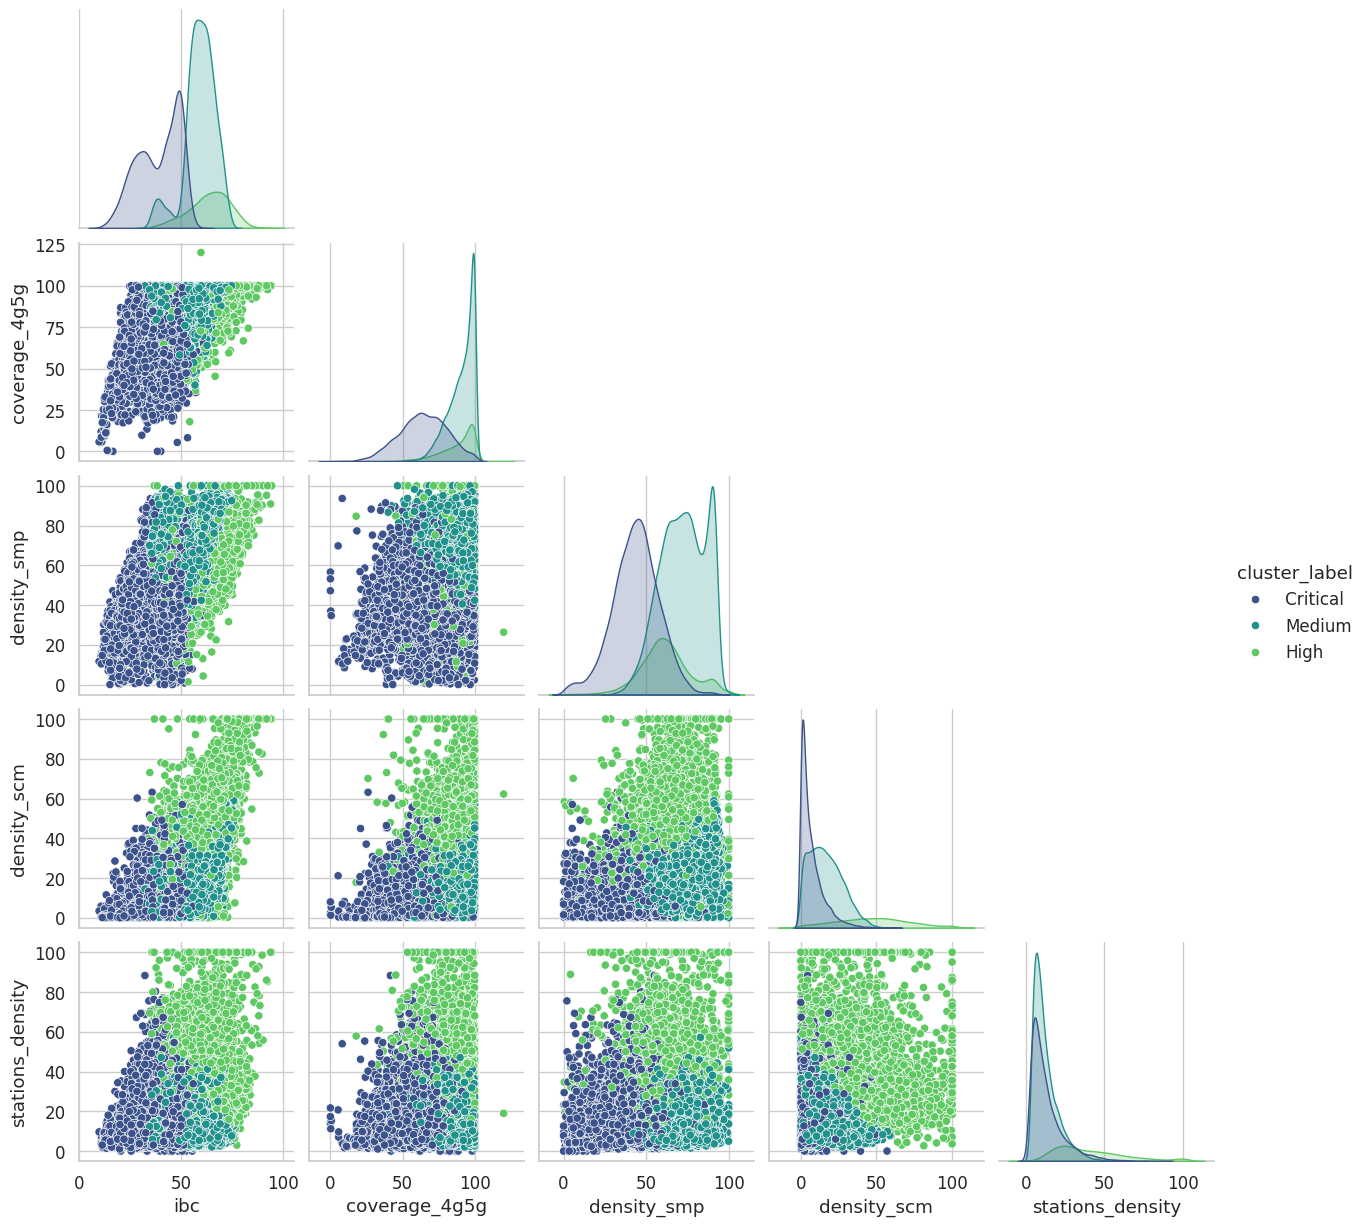

In [31]:
sns.pairplot(
    df_clust[features + ["cluster_label"]],
    hue="cluster_label",
    corner=True,
    palette="viridis"
)
plt.savefig("../reports/figures/clusters/pairplot_clusters.png", dpi=300)
plt.show()

# Save CSV

In [32]:
df_clust.to_csv("../data/processed/municipalities_clustered.csv", index=False)